In [1]:
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

In [2]:
from functions import *

In [2]:
#optimize_once TEST  --->  A-OK
new_pop = Population(10)
x = np.linspace(0.01,math.pi,100)
y = 2*x
data = {"x":x,"y":y}
specimen = new_pop.population[3]
graphtype = lib[specimen.graph[specimen.find_output_node()]["lib_id"]]
#print(graphtype)
for n in range(30):
    optimization = specimen.optimize_once(data)
    values = optimization["values"]
optimization

/Users/david/Documents/GitHub/Long-Term-Memory-AI/functions.py:183: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if parameters == None:


{'X': 0,
 'error': 8.2924599120016129e-17,
 'values': array([ 0.72602773,  2.        ])}

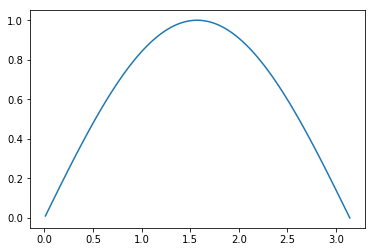

0-th year, population size = 5
1-th year, population size = 5
2-th year, population size = 5
3-th year, population size = 6
4-th year, population size = 6


/Users/david/Documents/GitHub/Long-Term-Memory-AI/functions.py:183: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if parameters == None:


5-th year, population size = 6
6-th year, population size = 6
7-th year, population size = 6
8-th year, population size = 6
9-th year, population size = 6
10-th year, population size = 6
11-th year, population size = 6
12-th year, population size = 6
13-th year, population size = 7
14-th year, population size = 7
15-th year, population size = 7
16-th year, population size = 7
17-th year, population size = 7
18-th year, population size = 7
19-th year, population size = 7
20-th year, population size = 8
21-th year, population size = 8
22-th year, population size = 8
23-th year, population size = 8
24-th year, population size = 8
25-th year, population size = 8
26-th year, population size = 8
27-th year, population size = 8
28-th year, population size = 8
29-th year, population size = 8
30-th year, population size = 8
31-th year, population size = 8
32-th year, population size = 8
33-th year, population size = 8
34-th year, population size = 8
35-th year, population size = 8
36-th year, p

252-th year, population size = 15
253-th year, population size = 15
254-th year, population size = 15
255-th year, population size = 15
256-th year, population size = 15
257-th year, population size = 15
258-th year, population size = 15
259-th year, population size = 15
260-th year, population size = 15
261-th year, population size = 15
262-th year, population size = 15
263-th year, population size = 16
264-th year, population size = 16
265-th year, population size = 16
266-th year, population size = 16
267-th year, population size = 16
268-th year, population size = 16
269-th year, population size = 16
270-th year, population size = 17
271-th year, population size = 17
272-th year, population size = 17
273-th year, population size = 17
274-th year, population size = 17
275-th year, population size = 17
276-th year, population size = 17
277-th year, population size = 17
278-th year, population size = 17
279-th year, population size = 17
280-th year, population size = 17
281-th year, p

/Users/david/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/david/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/david/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/david/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is de

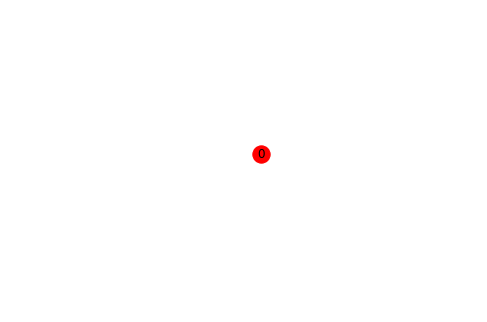

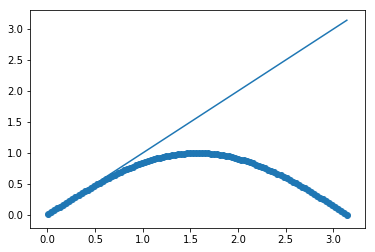

93.7022918937


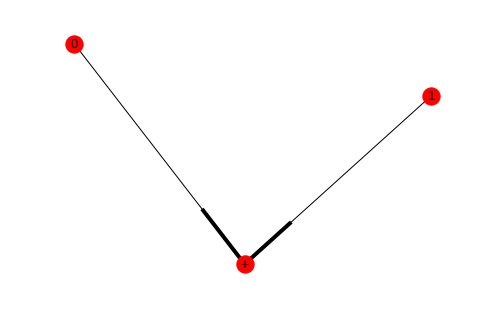

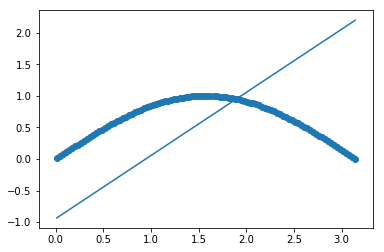

93.7022918937


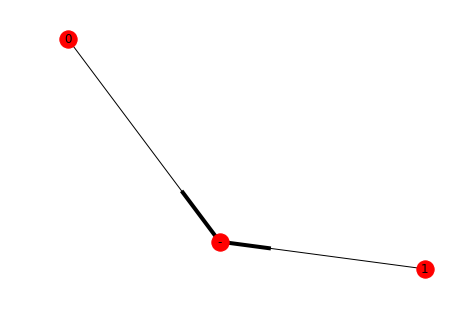

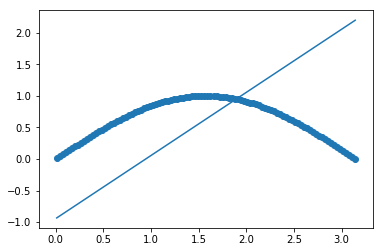

19.9251812281


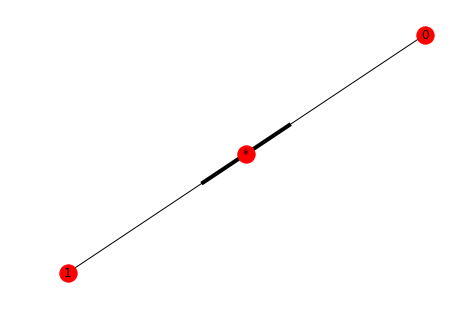

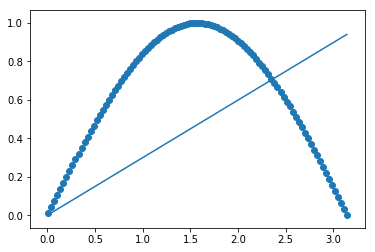

19.962317382


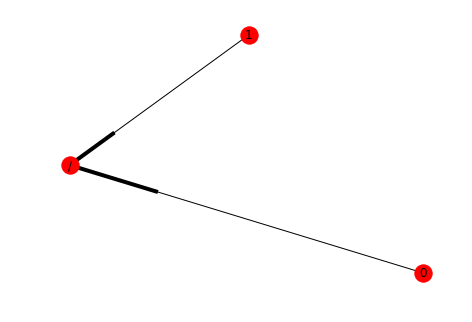

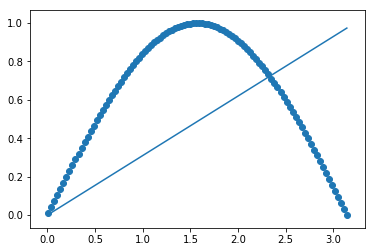

49.6580532754


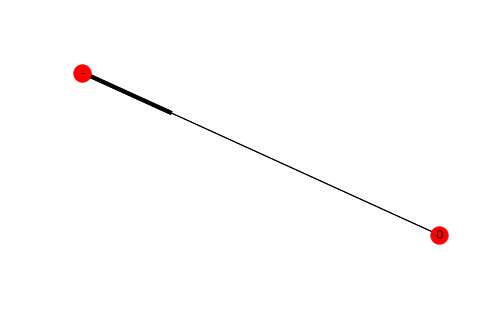

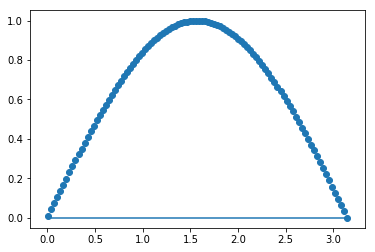

9.68310907632


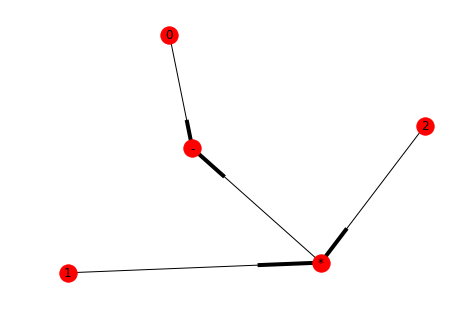

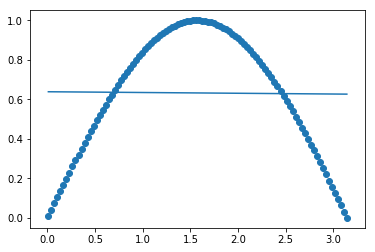

19.9251812281


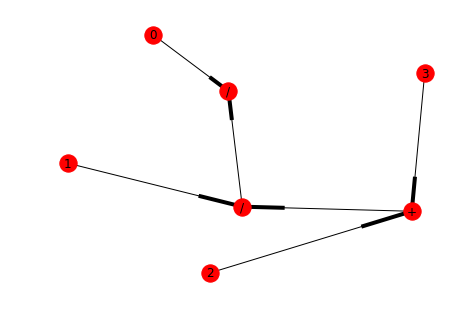

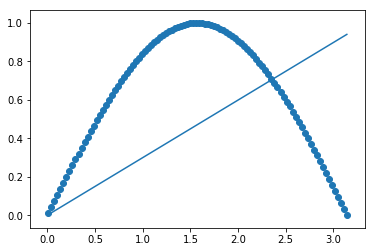

8.73904029681


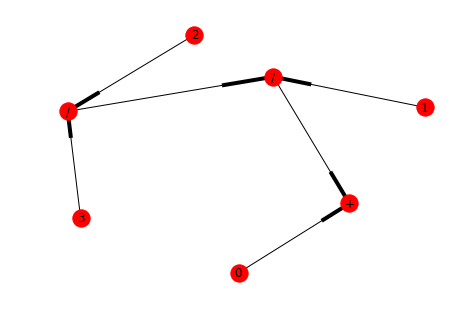

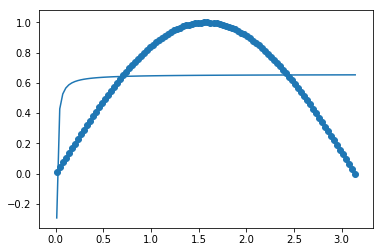

9.68434886808


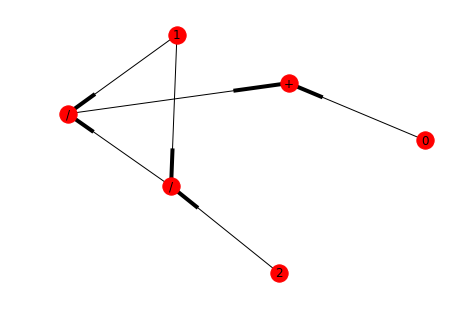

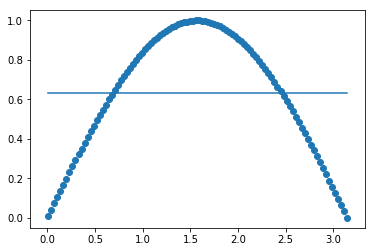

9.68310926112


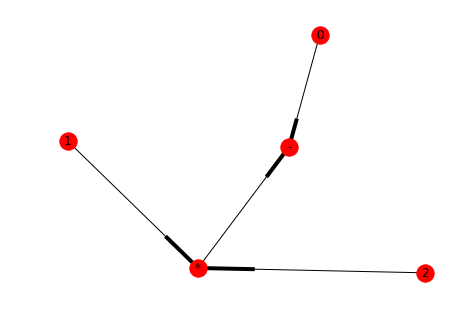

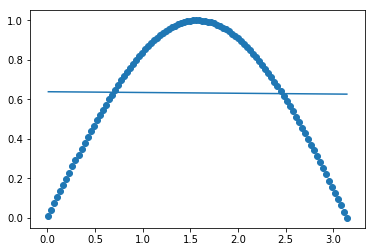

92.4162589316


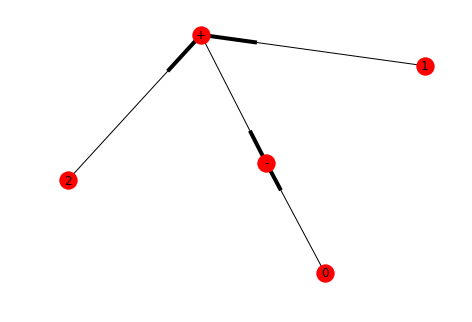

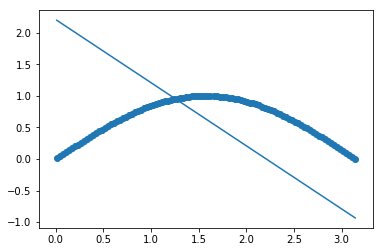

93.7022918937


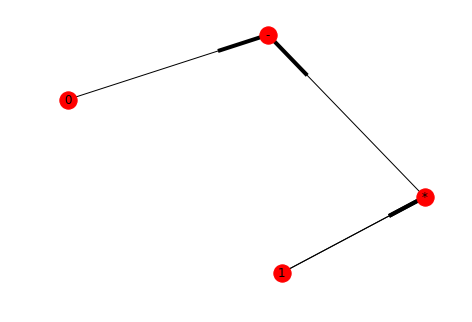

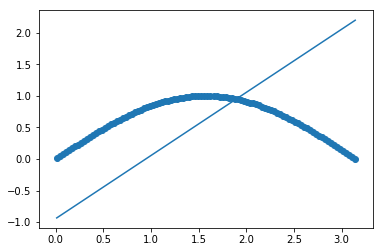

93.7022918937


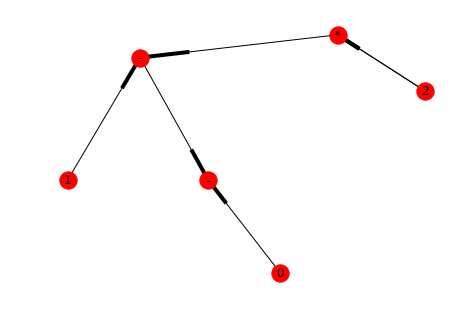

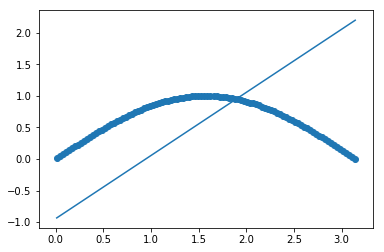

19.9251812281


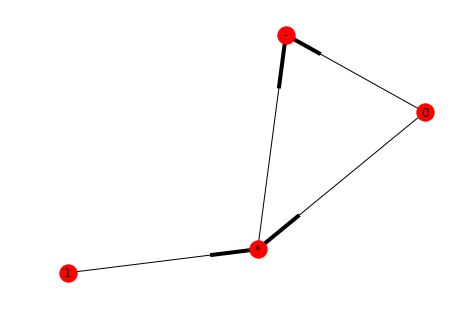

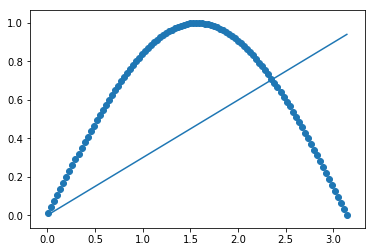

20.5584227667


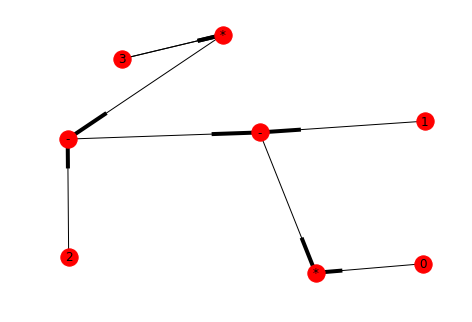

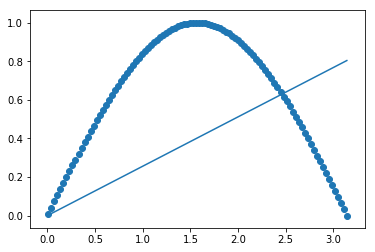

966.810087089


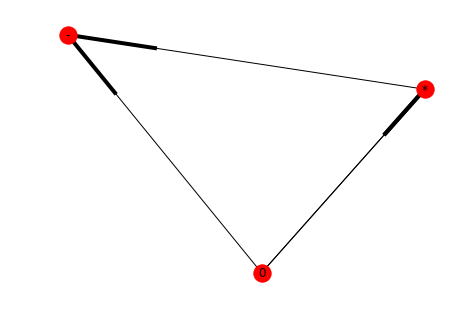

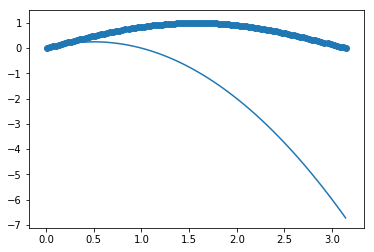

2
[ 0.65602208  0.23627913  0.65816449 -0.04019958]
8.73904029681


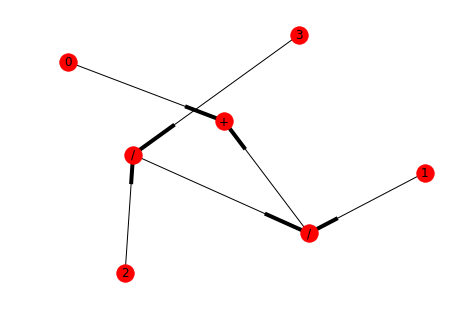

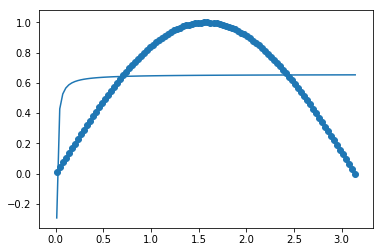

In [6]:
population = Population(10)
x = np.linspace(0.01,math.pi,100)
y = np.sin(x)#2*x+3
data = {"x":x,"y":y}
plt.plot(x,y)
plt.show()
population.evolve(data,generations=300)
for specimen in population.population:
    print(specimen.error(data))
    specimen.draw()
    specimen.plot_with_data(data,x_range=[0.01,math.pi])
specimen = population.best_specimen(data)
lib[specimen.graph[specimen.find_output_node()]["lib_id"]]
print(specimen.variable_position)
print(specimen.values)
print(specimen.error(data))
specimen.draw()
specimen.plot_with_data(data,x_range=[0.01,math.pi])